In [1]:
"""
Let's start with importing the modules we will use.
"""

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt

First, we must initialize the parameters that we will use to describe the time series. At minimum, we must tell the program the type of dynamics, the dimensions of the trajectories and the number of states. It will assume an autoregressive order of 1 unless told otherwise.

In [54]:
dynamics = 'AR'  # the type of dynamics (AR = autoregressive)
dim = 2  # number of trajectory dimensions
nstates = 3  # number of independent states

T = np.array([[0.99, 0.005, 0.005], [0.01, 0.98, 0.01], [0.02, 0.03, 0.95]])
cov = np.array([[[0.1, 0.00], [0.00, 0.1]], [[.25, 0.00], [0.00, 0.25]], [[0.40, 0.00], [0.00, 0.40]]])
phis = np.array([[[0.1, 0], [0, -0.3]], [[-0.7, 0.0], [0.0, 0.2]], [[0.45, 0.0], [0.0, -0.2]]])

T2 = np.array([[0.93, 0.01, 0.06], [0.02, 0.96, 0.02], [0.03, 0.03, 0.94]])
cov2 = np.array([[[0.55, 0.0], [0.0, 0.55]], [[0.7, 0.0], [0.0, 0.7]], [[0.9, 0.0], [0.0, 0.9]]])
phis2 = np.array([[[0.2, 0], [0, -0.45]], [[-0.3, 0.0], [0.0, 0.3]], [[0.5, 0.0], [0.0, -0.3]]])

trajectory_generator = gent.GenData(dynamics, dim, transition_matrix=T, phis=phis, cov=cov)
trajectory_generator2 = gent.GenData(dynamics, dim, transition_matrix=T2, phis=phis2, cov=cov2)

In [55]:
ntraj = 1  # generate 1 multi-dimensional trajectory
nsteps = 2000  # number of time steps in trajectory

trajectory_generator.gen_trajectory(nsteps, ntraj)
trajectory_generator2.gen_trajectory(nsteps, ntraj)

And now plot them to see what they look like. It is clear that the types of fluctuations are changing frequently. Note that each trajectory is just noise about 0. 

(2000, 1, 2)


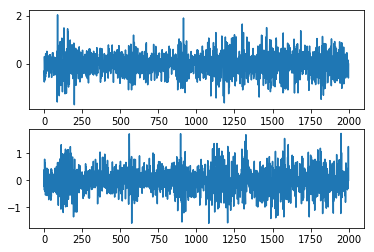

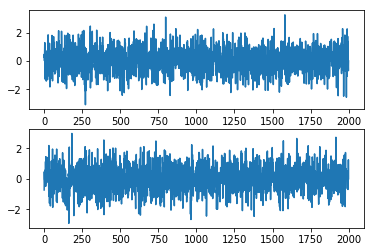

In [56]:
fig, ax = plt.subplots(2, 1)
fig, ax2 = plt.subplots(2, 1)

ax[0].plot(trajectory_generator.traj[:, 0, 0])
ax[1].plot(trajectory_generator.traj[:, 0, 1])

ax2[0].plot(trajectory_generator2.traj[:, 0, 0])
ax2[1].plot(trajectory_generator2.traj[:, 0, 1])
print(trajectory_generator.traj.shape)
plt.show()

# Estimating the latent state sequnce with the HDPHMM

Now let's use the HDPHMM to estimate the latent state sequence and the AR parameters of the test data. We will first initialize the InfiniteHMM class using the trajectory_generator object. Then we will run the algorithm for a set number of iterations. 

Remember, we aren't providing the algorithm with anything other than the raw trajectory data.

In [57]:
# combine trajectories
trajectory_generator.traj = np.concatenate((trajectory_generator.traj, trajectory_generator2.traj), axis=0)
trajectory_generator.state_sequence = np.concatenate((trajectory_generator.state_sequence, trajectory_generator2.state_sequence + 3), axis=0)
print(trajectory_generator.traj.shape)
print(trajectory_generator.state_sequence.shape)

(4000, 1, 2)
(4000, 1)


In [58]:
niter = 200  # number of iterations to cycle through
ihmm = hdphmm.InfiniteHMM(trajectory_generator)
ihmm.inference(niter)

  0%|          | 0/200 [00:00<?, ?it/s]

Fitting 1 2 dimensional trajectories assuming an autoregressive order of 1


100%|██████████| 200/200 [00:50<00:00,  3.91it/s]


Now it's time to see how the algorithm did.

Found 4 unique states
6 states were used to generate this data
Less states were found than exist...adding a dummy state

Estimated Transition Matrix:

[[0.9928 0.0002 0.006  0.     0.     0.0011]
 [0.0001 0.9938 0.0061 0.     0.     0.    ]
 [0.0083 0.0028 0.9873 0.     0.     0.0017]
 [0.0009 0.     0.0053 0.9938 0.     0.    ]
 [0.0097 0.0001 0.0023 0.     0.9878 0.0002]
 [0.     0.     0.0011 0.     0.     0.9989]]
Correctly identified 60.3 % of states


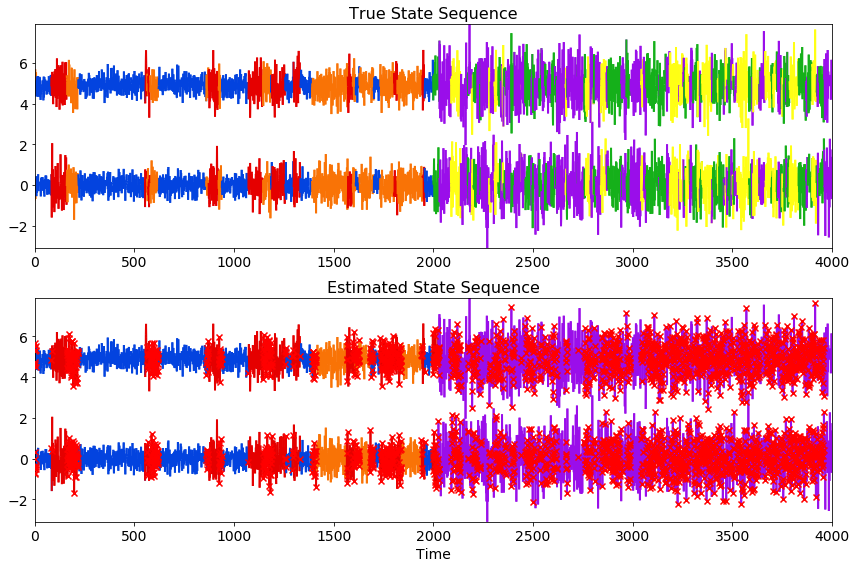

In [59]:
ihmm.summarize_results(traj_no=0)

Not bad! If you are generating trajectories using the same parameters as me, you should be getting about 96 % of the latent states correct. If you're not getting good results try calling the inference method again, perhaps with more iterations.